In [212]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from math import sqrt

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [213]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
housing_csv = pd.read_csv(data)

In [214]:
df = housing_csv.copy()
df.columns = df.columns.str.lower()

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [216]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [217]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])].copy()

In [218]:
df = df.fillna(0)

In [219]:
df['median_house_value'] = np.log(df['median_house_value'])

In [220]:
X = df.drop('median_house_value', axis=1).copy()
y = df['median_house_value']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, train_size=0.6, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [221]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [222]:
dv = DictVectorizer(sparse=True)
train_dict = df_train.to_dict(orient='records')
dv_fitted = dv.fit(train_dict)

In [223]:
val_dict = df_val.to_dict(orient='records')
X_val = dv_fitted.transform(val_dict)
X_train = dv_fitted.transform(train_dict)

In [104]:
#Q1

<9411x10 sparse matrix of type '<class 'numpy.float64'>'
	with 84699 stored elements in Compressed Sparse Row format>

In [109]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [117]:
list(zip(dv_fitted.get_feature_names_out(), dt.feature_importances_))

[('households', 0.0),
 ('housing_median_age', 0.0),
 ('latitude', 0.0),
 ('longitude', 0.0),
 ('median_income', 0.0),
 ('ocean_proximity=<1H OCEAN', 0.0),
 ('ocean_proximity=INLAND', 1.0),
 ('population', 0.0),
 ('total_bedrooms', 0.0),
 ('total_rooms', 0.0)]

In [113]:
# ('ocean_proximity=INLAND', 1.0),

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [63]:
#Q2

In [120]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [124]:
y_pred = rf.predict(X_val)
rmse = sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.2454364295869227


In [ ]:
#0.2454364295869227

In [ ]:
#Q3

In [176]:
e_scores = []
for e in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=e,random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))
    e_scores.append(( e , rmse))
    #print(rmse)
df_e_scores = pd.DataFrame(e_scores, columns=['n_estimators', 'rmse'])
df_e_scores

0.24543642958692266
0.23864199163579308
0.23732745326530955
0.23583413927847605
0.23565647119635627
0.23528222212209635
0.23488203321286513
0.23487965278972942
0.23462486831034615
0.23451596861374086
0.23442029401102765
0.23422033674947323
0.23401871422268994
0.23368585114693088
0.23348224851968835
0.23337793887482922
0.2333272742529523
0.23348967559264372
0.23370008988274749
0.23360432342980145


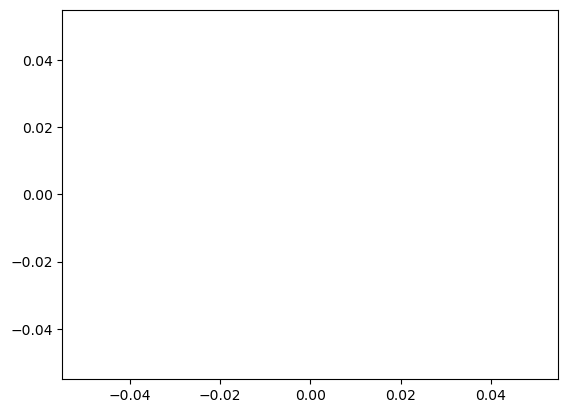

In [182]:
plt.plot(df_e_scores.n_estimators, df_e_scores.rmse)
#plt.ylim(0.230, 0.240)

In [ ]:
#10

In [ ]:
#Q4

In [183]:
scores = []
for d in [10, 15, 20, 25]:
    for e in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=e, max_depth=d,random_state=1,n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = sqrt(mean_squared_error(y_val, y_pred))
        scores.append(( d , e, rmse))
        #print(d, e , rmse)
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators',  'rmse'])
df_scores

10 10 0.2503817175522151
10 20 0.2473204397884821
10 30 0.24607880553877165
10 40 0.24474669658557988
10 50 0.24528525978272855
10 60 0.24525559325800772
10 70 0.24523695535604706
10 80 0.24537690161784595
10 90 0.24522653195314362
10 100 0.24503348738887515
10 110 0.24508436590963986
10 120 0.24483536428634967
10 130 0.24464669756777754
10 140 0.24432928272980822
10 150 0.2443107944537605
10 160 0.24422893464071868
10 170 0.2441718567639965
10 180 0.2443169087022996
10 190 0.2444713388426958
10 200 0.2445027275026326
15 10 0.24487149940789937
15 20 0.2387854254068034
15 30 0.23760570454041255
15 40 0.23591867404737593
15 50 0.23596464923659907
15 60 0.23590688549279432
15 70 0.2356927607824458
15 80 0.23606504621482674
15 90 0.23576525207044458
15 100 0.23544355561523156
15 110 0.2353622935093368
15 120 0.2351807437707409
15 130 0.23497679150529194
15 140 0.23470707609329075
15 150 0.23457508813121533
15 160 0.23443448732537722
15 170 0.23441648348102828
15 180 0.23459252248729143
15 

In [187]:
df_d_scores.groupby(['max_depth']).mean().round(4)

,n_estimators,rmse
max_depth,,
10,105.0,0.2452
15,105.0,0.2360
20,105.0,0.2348
25,105.0,0.2350


In [ ]:
#20

In [ ]:
#Q5

In [189]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [208]:
a = pd.Series([e[0] for e in list(zip(dv_fitted.get_feature_names_out(), rf.feature_importances_))])
b= pd.Series([e[1] for e in list(zip(dv_fitted.get_feature_names_out(), rf.feature_importances_))])
dfc = pd.concat([a,b], axis=1)
dfc[dfc[0].isin(['total_rooms',
'median_income',
'total_bedrooms',
'longitude'])]

,0,1
3,longitude,0.086834
4,median_income,0.335320
8,total_bedrooms,0.015466
9,total_rooms,0.021493


In [ ]:
#median_income

In [ ]:
#Q6

In [226]:
import xgboost as xgb


In [257]:
features = dv_fitted.get_feature_names_out()
features[5] = 'ocean_proximity_inf_1H_OCEAN'
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [259]:
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [262]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [265]:
y_pred = model.predict(dval)
rmse = sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.22858748687039102


In [266]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [267]:
y_pred = model.predict(dval)
rmse = sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.23123388171260645


In [ ]:
#0.3